# Differential equation (Langevin equation)

This function g models the effect of the equation:
$$\frac{\partial \sigma_i}{\partial t}  = -\frac{\partial V}{\partial \sigma_i} +
\sum_j J_{ij} \sigma_j + h_i\sigma_i + \xi_i(t)$$

with $V = \lambda (\sigma_i^2 - 1)^2$ so that $\frac{\partial V}{\partial\sigma_i} = 4\lambda(\sigma_i^2 - 1)\sigma_i$. This term is added to ensure that $\sigma_i$ decays exponentially to either $\pm 1$ within a time $\tau \sim \frac{1}{\lambda}$

The $\xi_i(t)$ term represents Gaussian White Noise

$$ \langle \xi_i(t) \xi_j(t') \rangle = 2T\delta_{ij}\delta(t-t')$$
i.e., $\xi_i(t)$ follows a $N(0, 2T)$, there is no correlation between the noise of different spins  ($i \neq j$) and the process is Markovian and therefore has no memory (the correlation is only nonzero when $t = t'$)

# Finite differences

Now we have to translate this differential equation into some finite difference equation. Since the neural network works with integer time increments, the exponential decay dynamics must be fast in times of order 1 and the Ising dynamics must be "slow"

$$\sigma_i(t+1) - \sigma_i(t) = dt\left(-4\lambda(\sigma_i^2 - 1)\sigma_i + \sum_j J_{ij} \sigma_j + h_i\sigma_i + \xi_i(t) \right)$$

absorbing 4 into $\lambda$ and clearing $\sigma_i(t+1)$:

$$g (\sigma_i(t)) = \sigma_i(t+1)= dt\left(-\lambda(\sigma_i^2 - 1)\sigma_i +  \sum_j J_{ij} \sigma_j + h_i\sigma_i + \xi_i(t) \right) + \sigma_i(t)$$

This will be our dynamical function $g (\sigma_i(t))$ defined later in the code

# Values of the dynamical parameters

 The values of the parameters are very important for the model to converge suscessfully.Too big parameter values (close or bigger than one) will cause the network to oscilate wildly trying to overcompensate the errors, while small values will converge very slowly but safely. There are another also other effects when varying $\epsilon$ and $\lambda$.

In [1]:
import numpy as np
# define functions and parameters T, lamb, dt
T = 0.0
lamb = 500.0
dt = 0.01
def g(state_t0, weights):
    h = np.dot(weights, state_t0)
    xi = np.sqrt(2*T*dt)*np.random.randn(np.size(state_t0))
    state_t1 = dt*(-lamb*(state_t0**2 - 1)*state_t0 + h) + xi + state_t0
    return state_t1

$$J_{ij} = \frac{1}{N}\sum_{\lambda=1}^K m_i^{(\lambda)} m_j^{(\lambda)}$$

$m_i^{(\lambda)}$ can be written as a slice of a [Hadamard matrix](https://en.wikipedia.org/wiki/Hadamard_matrix), since the patterns have to be orthogonal, $\sum_i m_i^{(\lambda)} m_i^{(\lambda')} = 0 $ if $\lambda \neq \lambda'$
$i = 1..N$ and $\lambda = 1..K$. $N = L^2$ is the size of the newtork and $K$ is the number of stationary states of the system (memory patterns)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from neurodynex.hopfield_network import network, pattern_tools, plot_tools
from scipy.linalg import hadamard


def get_stationary(N, K):

    had_size = 2**np.ceil(np.log2(N))
    # had_size has to be a power of two
    H = np.squeeze(hadamard(had_size)) # Orthogonal patterns
    
    if K == 1:
        H = H[0:N, L:L+1] 
    else:
        H = H[0:N, 0:K]
    return H

## Parameters
L = 10 # size of the newtork
N = L**2
K = 1 # number of stationary states of the system (memory patterns)
lamb = 0.0
dt = 0.01
T = 0.0 # Temperature
nsteps = 10 # number of steps of the simulation

def iterate_plot(nsteps, flips=-1, pattern=-1):
    """
    iterate_plot(nsteps, flips=-1, pattern=-1)
    iterate nsteps and plot time evolution, final state and all stationary patterns
    flips is the number of spin flipped from the stationary pattern
    pattern is the number of the stationary pattern as given below by the very function
    (P0, P1, P2, P3, P4, ...)
    """

    H = get_stationary(N, K)

    # create an instance of the class HopfieldNetwork
    hopfield_net = network.HopfieldNetwork(nr_neurons=N)
    # instantiate a pattern factory
    factory = pattern_tools.PatternFactory(L, L)

    # einstein summation convention, sum in lambda index
    hopfield_net.weights = 1/N*np.einsum('ik,jk->ij', H, H)

    # set user defined function to update the state
    hopfield_net.set_dynamics_to_user_function(g)
    # hopfield_net.set_dynamics_sign_sync()

    stationary = np.squeeze(H) # this should be an stationary state

    if flips == -1:
        hopfield_net.state = hopfield_net.state # random initial state
    elif pattern == -1 or K == 1:
        # flip some spins from the stat state (only one stationary state)
        hopfield_net.state = pattern_tools.flip_n(stationary, nr_of_flips=flips)
    else:
        # flip some spins from the stat state (more than one stationary state)
        hopfield_net.state = pattern_tools.flip_n(stationary[:, pattern], nr_of_flips=flips) 

    states = hopfield_net.run_with_monitoring(nr_steps=nsteps)

    # each network state is a vector. reshape it to the same shape used to create the patterns.
    states_as_patterns = factory.reshape_patterns(states[0:nsteps:round(nsteps/10)])
    # plot the states of the network (10 equispaced states)
    old = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = (20, 20) # Bigger size
    plot_tools.plot_pattern_list(states_as_patterns)
    plt.rcParams["figure.figsize"] = old

    # plot final state to compare it against the stationary state
    plot_tools.plot_pattern(np.reshape(states[-1], (L, L)))
    print('Final state')

    if len(np.shape(np.squeeze(H))) < 2:
        plot_tools.plot_pattern(np.reshape(H, (L, L)))
        print('Stationary state')

    else:

        H_patterns = factory.reshape_patterns(H.T)
        print(np.shape(H.T))
        old = plt.rcParams["figure.figsize"]
        plt.rcParams["figure.figsize"] = (20, 20) # Bigger size
        plot_tools.plot_pattern_list(H_patterns)
        plt.rcParams["figure.figsize"] = old
        print('Stationary states')
    return states, hopfield_net.weights



Metastable state with initial pattern 6 at $T = 0$. Run this cell until you found a metastable pattern

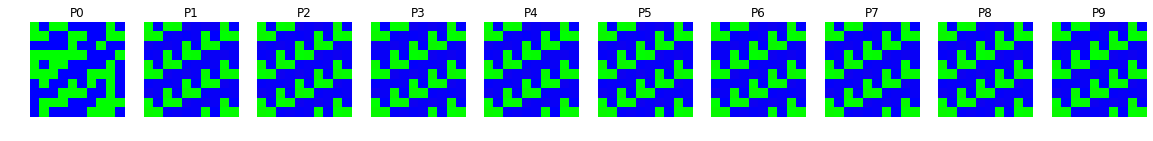

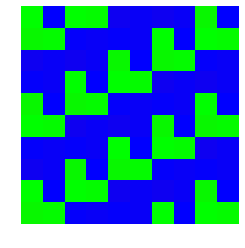

Final state
(10, 100)


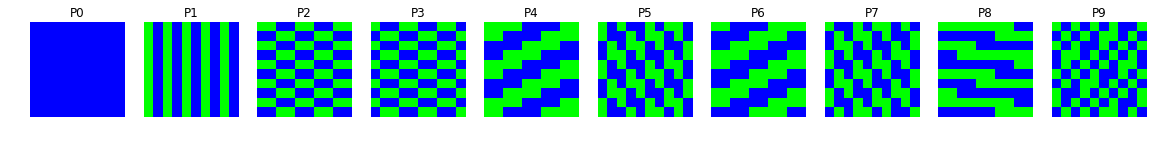

Stationary states


Text(0, 0.5, '<|g(s)-s|>')

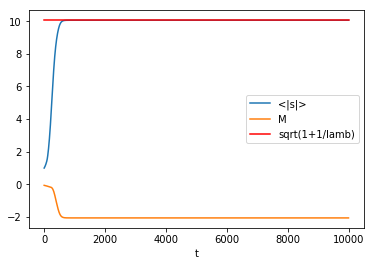

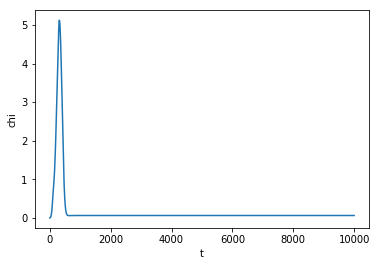

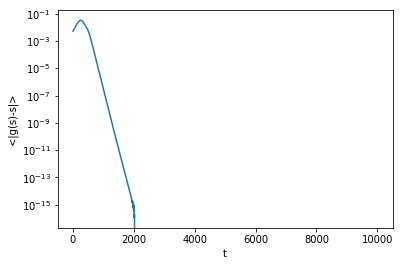

In [23]:
import matplotlib.pyplot as plt
L = 10 # size of the newtork
N = L**2
K = int(0.1*N)
dt = 0.01
lamb = 0.01
T = 0.00 # Temperature
nsteps = 10000 # number of steps of the simulation

states, weights = iterate_plot(nsteps, 25, 4)


plt.figure(1)
abs_s = np.mean(np.abs(states), axis=1)
M = np.mean(states, axis=1)
plt.plot(abs_s)
plt.plot(M)
stat = np.sqrt(1+1/lamb) # converges to stat instead of +/- 1
plt.plot([0, len(abs_s)], [stat, stat], 'r')
plt.xlabel('t')
plt.legend(['<|s|>', 'M', 'sqrt(1+1/lamb)'])

# E = -np.einsum('ik->k', np.einsum('ij,kj->ik', weights, states))
# plt.figure(2)
# plt.plot(E)
# plt.xlabel('t')
# plt.ylabel('E')

chi = np.var(np.abs(states), axis=1)
plt.figure(4)
plt.plot(chi)
plt.xlabel('t')
plt.ylabel('chi')

plt.figure(5)
conv = [g(x, weights) - x for x in states] # should be 0 for a stationary pattern with T = 0
conv = np.mean(np.abs(conv), axis=1)
plt.semilogy(conv)
plt.xlabel('t')
plt.ylabel('<|g(s)-s|>')

Convergence to $\pm 1$ (rerun the cell above, bigger nsteps may be needed with increasing $\lambda$)

| $\lambda$ | 0.125 | 0.25 | 0.5 | 1.0 | 2.0 |
|-----------|-------|------|-----|-----|-----|
|   $|s|$   |  3.0  |  2.2 | 1.7 | 1.4 | 1.2 |




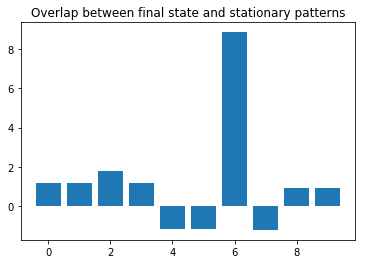

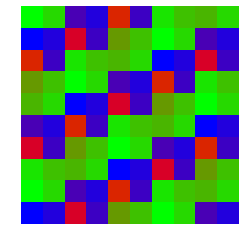

Final state


In [8]:
plt.figure(1)
H = get_stationary(N, K)
overlap = [pattern_tools.compute_overlap(states[-1], x) for x in H.T]
plt.bar(np.arange(0, K), overlap)
plt.title('Overlap between final state and stationary patterns')
metastable = np.dot(overlap, H.T) # Reconstruct metastable pattern
plot_tools.plot_pattern(np.reshape(metastable, (L, L)))
print("Final state")